In [22]:
# Hyperparameters
seq_length = 30 #window
batch_size = 16
hidden_size = 3  # Number of neurons in the hidden layers
num_layers = 1  # Number of hidden layers
learning_rate = 0.0001
num_epochs = 300
starting_point =  50 #cutoff first 50 points

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import maketab as mt
import math

In [24]:
def normalize(train_data):
    mins = np.min(train_data, axis=1, keepdims=True)
    maxs = np.max(train_data, axis=1, keepdims=True)
    normalized_train = (train_data - mins) / (maxs - mins)
    params = {'mins': mins, 'maxs': maxs}   
    return normalized_train, params

def denormalize(normalized_train, params):
    mins = params['mins']
    maxs = params['maxs']
    denormalized_train = normalized_train * (maxs - mins) + mins    
    return denormalized_train

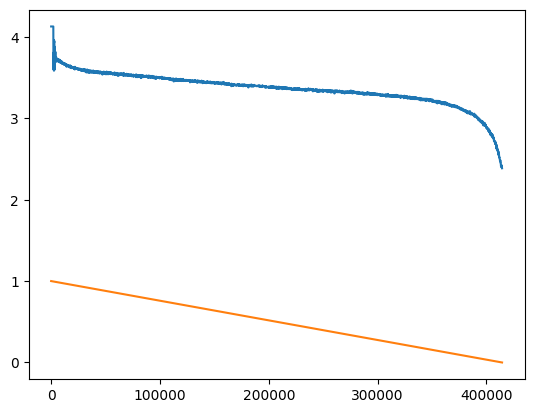

In [25]:
#"""
def load_data(path_dir):
    t, signal = mt.battery(path_dir)
    tleft = 1 - t / max(t)  
    return signal, tleft, t
#"""

"""
f_num = math.floor(len(signal)/seq_length)
    signal = signal[:f_num*seq_length]
    tleft = tleft[:f_num*seq_length]
    t = np.empty(0)
    t_ap = np.arange(0, seq_length)*100
    for i in range(f_num):
        t = np.append(t, t_ap)

        
def load_data(path_dir):
    t = mt.time(path_dir)
    tleft = 1 - t / max(t)
    motor = mt.readcsv(path_dir+'motor.csv')
    motor = (motor/65535)*100
    thr = mt.thrust(path_dir)
    av = mt.ang_vel(path_dir)
    #me = thr*0.05*av*0.1
    me = ((thr[1]/4)*av[1] + (thr[2]/4)*av[2] + (thr[3]/4)*av[3] + (thr[4]/4)*av[4])*0.047*0.1*0.05
    return me, tleft, t
"""

train_data = load_data('data/31-1-25/')
more_train_data = load_data('data/4-2-25/')
test_data = load_data('data/5-2-25/')
#train_data, train_param = normalize(train_data)
#test_data, test_param = normalize(test_data)
plt.plot(train_data[2], train_data[0])
plt.plot(train_data[2], train_data[1])
plt.show()

In [26]:
def prep_data(data, seq_length, step=1):
    input_data = data[0]
    output_data = data[1]
    time_data = data[2]
    xs, ys = [], []
    for i in range(starting_point, len(input_data) - seq_length, step):
        x = input_data[i:i + seq_length]
        y = output_data[i:i + seq_length]
        #t = time_data[i:i + seq_length]
        t = np.linspace(0, 1, seq_length)
        
        slope2, slope, intercept = np.polyfit(t, x, 2)
        mean = np.mean(x)
        std = np.std(x)
        xs.append((slope2, slope, intercept, mean, std))

        slope2, slope, intercept = np.polyfit(t, y, 2)
        mean = np.mean(y)
        std = np.std(y)
        ys.append((slope2, slope, intercept, mean, std))
        
    xs = np.array(xs)
    ys = np.array(ys)
    
    X_train = torch.tensor(xs, dtype=torch.float32)  # Shape: (batch_size, seq_length)
    y_train = torch.tensor(ys, dtype=torch.float32)  # Shape: (batch_size, seq_length)
    return X_train, y_train

X_train, y_train = prep_data(train_data, seq_length)
X_train_more, y_train_more = prep_data(more_train_data, seq_length)
X_test, y_test = prep_data(test_data, seq_length)

X_train = torch.cat((X_train, X_train_more), dim=0)
y_train = torch.cat((y_train, y_train_more), dim=0)

# Create training DataLoader for batching
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [27]:
input_size = X_train.shape[1]
output_size = y_train.shape[1]

In [28]:
# Define the MLP model
'''
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out
'''

'\nclass MLP(nn.Module):\n    def __init__(self, input_size, hidden_size, output_size):\n        super(MLP, self).__init__()\n        self.fc1 = nn.Linear(input_size, hidden_size)\n        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)\n        self.fc3 = nn.Linear(hidden_size // 2, output_size)\n        self.relu = nn.ReLU()\n\n    def forward(self, x):\n        out = self.fc1(x)\n        out = self.relu(out)\n        out = self.fc2(out)\n        out = self.relu(out)\n        out = self.fc3(out)\n        return out\n'

In [29]:
#'''
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # Input to hidden layer
        self.fc2 = nn.Linear(hidden_size, output_size)  # Hidden to output layer
        self.relu = nn.ReLU()  # Activation function
        self.prelu = nn.PReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        out = self.fc1(x)  # Pass through the hidden layer
        #out = self.relu(out)  # Apply ReLU activation
        out = self.tanh(out)
        out = self.fc2(out)  # Pass through the output layer
        return out
#'''

In [30]:
# Initialize the model, loss function, and optimizer
model = MLP(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
#optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

In [31]:
# Training loop
def train(dataloader):
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            outputs = model(batch_X)  # Shape: (batch_size, seq_length)
            loss = criterion(outputs, batch_y)  # Ensure shapes match
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
    
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(dataloader):.4f}')

train(dataloader)

Epoch [10/300], Loss: 0.0322
Epoch [20/300], Loss: 0.0305
Epoch [30/300], Loss: 0.0291
Epoch [40/300], Loss: 0.0274
Epoch [50/300], Loss: 0.0254
Epoch [60/300], Loss: 0.0233
Epoch [70/300], Loss: 0.0210
Epoch [80/300], Loss: 0.0186
Epoch [90/300], Loss: 0.0161
Epoch [100/300], Loss: 0.0137
Epoch [110/300], Loss: 0.0113
Epoch [120/300], Loss: 0.0091
Epoch [130/300], Loss: 0.0073
Epoch [140/300], Loss: 0.0059
Epoch [150/300], Loss: 0.0050
Epoch [160/300], Loss: 0.0044
Epoch [170/300], Loss: 0.0042
Epoch [180/300], Loss: 0.0041
Epoch [190/300], Loss: 0.0040
Epoch [200/300], Loss: 0.0040
Epoch [210/300], Loss: 0.0040
Epoch [220/300], Loss: 0.0040
Epoch [230/300], Loss: 0.0040
Epoch [240/300], Loss: 0.0040
Epoch [250/300], Loss: 0.0040
Epoch [260/300], Loss: 0.0039
Epoch [270/300], Loss: 0.0039
Epoch [280/300], Loss: 0.0039
Epoch [290/300], Loss: 0.0039
Epoch [300/300], Loss: 0.0039


Trenovaci
error: 0.044619505937981904
prediction: 1.031416893005371
error: 0.03708996365765119
prediction: 1.0145416259765625
error: 0.005211975309798015
prediction: 0.9666575789451599
error: 0.03368036792993057
prediction: 0.931264340877533
error: 0.037954973951578014
prediction: 0.9188529253005981
error: 0.06645881609163533
prediction: 0.8843246102333069
error: 0.07549889559073954
prediction: 0.8683914542198181
error: 0.08167433304250975
prediction: 0.8544970154762268
error: 0.09021243249997851
prediction: 0.8394654989242554
error: 0.09225878627447878
prediction: 0.829502284526825
error: 0.10033574686142331
prediction: 0.81451016664505
error: 0.10125944835052311
prediction: 0.8066468238830566
error: 0.0978449843728101
prediction: 0.8031153082847595
error: 0.09882478359547327
prediction: 0.7948116660118103
error: 0.0972331606824436
prediction: 0.7891702055931091
error: 0.09036751849039974
prediction: 0.7881412506103516
error: 0.08696843208284451
prediction: 0.7845187783241272
error: 0

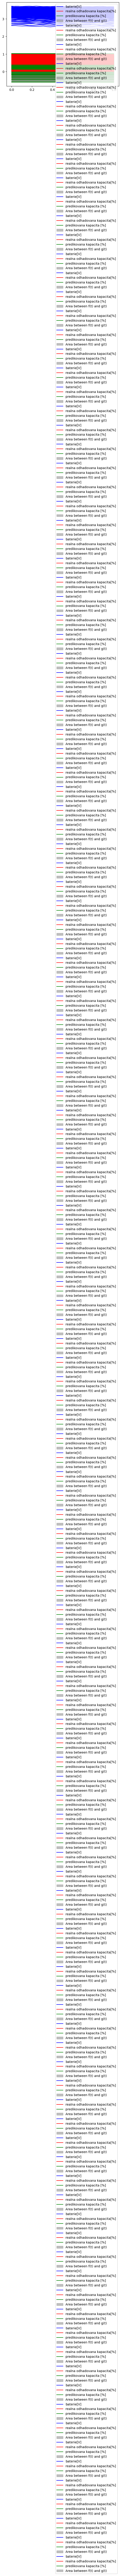

In [32]:
#slope2, slope, intercept, mean, std

def eval(data):
    model.eval()
    with torch.no_grad():
        
        input_data = data[0]
        output_data = data[1]
        for i in range(starting_point, len(input_data) - seq_length, seq_length):
            x = input_data[i:i + seq_length]
            t = np.linspace(0, 1, seq_length)
            y = output_data[i:i + seq_length]

            slope2, slope, intercept = np.polyfit(t, x, 2)
            mean = np.mean(x)
            std = np.std(x)

            X = torch.tensor((slope2, slope, intercept, mean, std), dtype=torch.float32)
            pred = model(X).numpy()
            reg = pred[0]*t**2 + pred[1]*t + pred[2]
            print(f"error: {np.mean(np.abs(y - reg))}")
            print(f"prediction: {pred[3]}") #print a mean
            
            plt.plot(t, x, c='blue', label="baterie[V]")
            plt.plot(t, y, c='red', label="realna odhadovana kapacita[%]")
            plt.plot(t, reg, c='green', label="predikovana kapacita [%]")
            plt.fill_between(t, y, reg, color='gray', alpha=0.5, label='Area between f(t) and g(t)')
            if (i <= starting_point): #otherwise it will print more than once
                plt.legend()
            #plt.scatter(t[0], intercept + np.absolute(intercept-pred[2]))
            #plt.scatter(t[0], pred[3], color="black", linewidth=1)
            #plt.show()

print("Trenovaci")
eval(train_data)
#plt.savefig("pow_train.png")
print("Testovaci")
eval(test_data)
#plt.savefig("pow_test.png")

In [33]:
# Save the state dictionary and architecture parameters
checkpoint = {
    'seq_length': seq_length,
    'num_layers': num_layers,
    'starting_point': starting_point,
    'input_size': input_size,
    'hidden_size': hidden_size,
    'output_size': output_size,
    'state_dict': model.state_dict(),
}
torch.save(checkpoint, 'bat_model.pth')